<a href="https://colab.research.google.com/github/arpark1231/resolutionsystem/blob/main/ML_Test_2_Nullsubjekt_anaphorisch_oder_nicht_anaphorish_08102019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:**

In this, we try to predict that if a zero subject anaphoric or non-anaphoric is by using LogisticRegression. (data: training_data_sample_102019.csv, 이를 split, feature를 One-hot Encoding을 통해 Engineering함, 테스트 점수: 0.80)

**Import necessary libraries**

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자(https://kaggle-kr.tistory.com/17)가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

**Import the training dataset**

In [ ]:
# Google Colab에서 Local Computer의 파일을 업로드할 수 있는 코드를 추가함
from google.colab import files
uploaded = files.upload()

Saving test_data_sample_102019.csv to test_data_sample_102019 (2).csv
Saving training_data_sample_102019.csv to training_data_sample_102019 (2).csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['training_data_sample_102019.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test_data_sample_102019.csv']))

# 이제 데이터셋이 판다스의 dataframe에 저장되었음, 추가한 코드들 덕분에 다시 아래 코드들이 정상적으로 돌아감
#importing the training data

In [ ]:
df_train.head(10)


,nr.,etri_sent,verb,verb_roman,candidate,candidate_roman,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,4529,부탁합니다,bu-tag-hab-ni-da,비행기시간,bi-hAN-gi-si-gan,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,1,4529,부탁합니다,bu-tag-hab-ni-da,거리,gO-li,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,2,4529,부탁합니다,bu-tag-hab-ni-da,밖,bagg,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,3,4726,맞는지,maj-nUn-ji,표,pyo,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,4,4726,맞는지,maj-nUn-ji,기차,gi-ca,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
5,5,4726,맞는지,maj-nUn-ji,파리행기차,pa-li-hAN-gi-ca,1,0,1,0,2,12,scom,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
6,6,4902,닫아주시길,dad-a-ju-si-gil,창문,caN-mun,0,0,0,0,0,2,modi,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
7,7,4902,닫아주시길,dad-a-ju-si-gil,덮개,dOp-gA,0,0,1,0,0,1,dobj,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
8,8,4902,닫아주시길,dad-a-ju-si-gil,비행기,bi-hAN-gi,0,0,1,0,0,4,subj,subj,1,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
9,9,4902,닫아주시길,dad-a-ju-si-gil,옆,yOp,0,0,0,0,3,16,modi,subj,0,A,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN


pandas dataframe 에는 describe() 메소드가 있는 데, 이를 쓰면 각 feature 가 가진 통계치들을 반환해줍니다.

In [ ]:
df_train.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


In [ ]:
df_test.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.000000,97.0,97.0,97.0,97.0
mean,1278.000000,4895.123711,0.206186,0.061856,0.525773,0.164948,1.412371,11.134021,0.309278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020619,0.0,0.0,0.0,0.0
std,28.145456,237.116368,0.406667,0.242145,0.501929,0.373062,1.048338,6.882388,0.464597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142842,0.0,0.0,0.0,0.0
min,1230.000000,4031.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
25%,1254.000000,4829.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
50%,1278.000000,5005.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
75%,1302.000000,5006.000000,0.000000,0.000000,1.000000,0.000000,2.000000,17.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
max,1326.000000,5009.000000,1.000000,1.000000,1.000000,1.000000,3.000000,27.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0


**범주형 데이터 문자열 확인하기**

*  데이터셋을 읽고 나면, 먼저 열에 어떤 의미 있는 범주형 데이터가 있는지 확인해보는 것이 좋습니다. 외부에서 다운받은 데이터일 경우, 정해진 범주 밖에 있을 수 있고, 철자 등의 typo가 있어서 데이터를 전처리해야 할 수 있습니다. 예를 들면 전화번호에 010-1234-5678과 01012345678처럼 같은 표현이지만 다르게 표현된 데이터가 있을 수 있습니다.

*  열의 내용을 확인하는 가장 좋은 방법은 pandas에서 Series에 있는 value_counts 함수를 사용하여 유일한 값이 각각 몇 번 나타나는 지 출력해보는 것입니다.

데이터 파일에서 feature들의 이름이 있는 열만 우선 불러오기.

In [ ]:
df_train.columns

Index(['nr.', 'etri_sent', 'verb', 'verb_roman', 'candidate',
       'candidate_roman', 'is_ana', 'topic_ant', 'head_ant', 'beginning_ant',
       'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj',
       'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2',
       'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9',
       'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono',
       'zp_mood'],
      dtype='object')

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
#feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
#categorical_feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
# categorical features는 전체 feature에서 continuous feature인 'sent_dist', 'token_dist'를 제외한 feature들이다.
print(df_train.topic_ant.value_counts())

0    212
1      8
Name: topic_ant, dtype: int64


topic_ant의 경우에는 0, 1로 에러없이 잘 나누어져있고, 정확하게 두 가지 값을 지니니 원-핫-인코딩으로 나타내기 좋은 형태입니다. 실제 데이터에서는 모든 열에 대해 확인해야 합니다.

In [ ]:
print(df_train.zp_hono.value_counts())

plus    52
Name: zp_hono, dtype: int64


zp_hono의 경우에는 honorific mark가 없는 것들은 N/A로 표시되었기 때문에 value_counts에서 plus 값만 보여준다.

pandas에서는 get_dummies 함수를 사용해 데이터를 매우 쉽게 인코딩할 수 있습니다. get_dummies 함수는 객체 타입이나 범주형을 가진 열을 자동으로 변환해줍니다.

In [ ]:
# 예제를 위해 is_ant(정답셋)을 포함한 feature들의 열만 선택합니다. 이 때 continuas feature도 포함합니다.
data = df_train[['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']]

display(data.head())

,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN


In [ ]:
print("original feature : \n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("get_dummies feature : \n", list(data_dummies.columns))

original feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj', 'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood'] 

get_dummies feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'both_subj/dobj', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'ant_syn_dobj', 'ant_syn_modi', 'ant_syn_root', 'ant_syn_scom', 'ant_syn_sub2', 'ant_syn_subj', 'zp_syn_subj', 'ant_speaker_A', 'ant_speaker_B', 'zp_speaker_A', 'zp_speaker_B', 'tense_zp_futu', 'tense_zp_past', 'tense_zp_pres', 'connective_pred_class_A', 'zp_hono_plus', 'zp_mood_decl', 'zp_mood_impe', 'zp_mood_ques']


data_dummies의 values 속성을 이용해 DataFrame을 NumPy 배열로 바꿀 수 있으며, 이를 이용해 머신러닝 모델을 학습시킵니다. 모델을 학습시키기 전에 이 데이터로부터 타깃값을 분리해야 합니다. 출력값이나 출력값으로부터 유도된 변수를 특성 표현에 포함하는 것은 지도 학습 모델을 만들 때 특히 저지를기 쉬운 실수입니다.

*  **CAUTION!**
  * pandas에서 열 인덱싱은 범위 끝을 포함합니다. 이와 달리 numpy는 끝 인덱싱은 범위 끝을 포함하지 않습니다.

여기서는 특성을 포함한 열, 즉 topic ant부터 zp_mood_ques까지 모든 열을 추출합니다. 이 범위에는 타깃(is_ana)을 뺀 모든 특성이 포함됩니다. (이 예제에서는 타깃값도 원-핫-인코딩으로 변환했지만, scikit-learn에서는 문자열도 타깃값으로 쓸 수 있으므로 imcome 열을 그대로 사용해도 됩니다.)

In [ ]:
features = data_dummies.loc[:, 'topic_ant':'zp_mood_ques']
# NumPy 배열 추출
X = features.values
y = data_dummies['is_ana'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))
# X.shape: (220, 37)  y.shape: (220,)

X.shape: (220, 37)  y.shape: (220,)


이제 데이터가 scikit-learn에서 사용할 수 있는 형태가 되었으므로, 로지스틱 회귀 분류기를 이용하면 됩니다.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(logreg.score(X_test, y_test)))
# 테스트 점수: 0.80

테스트 점수: 0.80


이 위의 코드까지가 LogisticRegression을 이용하여 test해본 결과

## Exploratory data analysis

*  이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.  
*  시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.  

### 1. zp_mood

*  먼저 zp_mood 에 대해서 살펴보겠습니다. zp_mood는 binary 데이터 타입입니다.  
*  먼저 zp_mood 에 따른 classification의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe 에서는 groupby 를 사용하면 쉽게 할 수 있습니다. 또한 pivot 이라는 메소드도 있습니다.
*  'zp_mood', 'is_ana' 를 가져온 후, zp_mood로 묶습니다. 그러고 나면 각 zp_mood마다 0, 1 이 count가 되는데, 이를 평균내면 각 zp_mood별 classification이 나옵니다
*  아래와 같이 count() 를 하면, 각 class 에 몇 개의 zp_mood가 있는 지 확인할 수 있으며, sum() 을 하면, 212개 중 anaphoric(is_ant=**1**)한 zero subject의 총합을 주게 됩니다

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).count()

,is_ana
zp_mood,
decl,109
impe,5
ques,44


=> training data에서 총 220개의 zero subject 중에 "zp_mood"라는 feature에서 N/A를 제외하면 총 158개의 zero subject 중에  109개가 decl(평서문)에서, 5개가 impe(명령문)에서, 44개가 ques(의문문)에서는 나타났다.

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).sum()

,is_ana
zp_mood,
decl,66
impe,0
ques,21


  *  pandas 의 crosstab 을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [ ]:
pd.crosstab(df_train['zp_mood'], df_train['is_ana'], margins=True).style.background_gradient(cmap='summer_r')

is_ana,0,1,All
zp_mood,,,
decl,43,66,109
impe,5,0,5
ques,23,21,44
All,71,87,158


  * grouped 객체에 mean() 을 하게 되면, 각 mood별 is_ana을 얻을 수 있습니다. decl이면 아래와 같습니다.

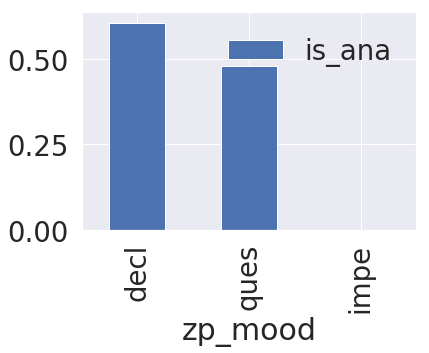

In [ ]:
df_train[['zp_mood', 'is_ana']].groupby(['zp_mood'], as_index=True).mean().sort_values(by='is_ana', ascending=False).plot.bar()

### 2. token_dist

*  이번에는 token_dist 를 살펴봅시다.

In [ ]:
print('제일 먼 token의 거리 : {:.1f} Tokens'.format(df_train['token_dist'].max()))
print('제일 가까운 token의 거리 : {:.1f} Token'.format(df_train['token_dist'].min()))
print('평균 token 거리 : {:.1f} Tokens'.format(df_train['token_dist'].mean()))

제일 먼 token의 거리 : 24.0 Tokens
제일 가까운 token의 거리 : 1.0 Token
평균 token 거리 : 9.9 Tokens


anaphoric에 따른 token_dist의 histogram 을 그려보겠습니다.


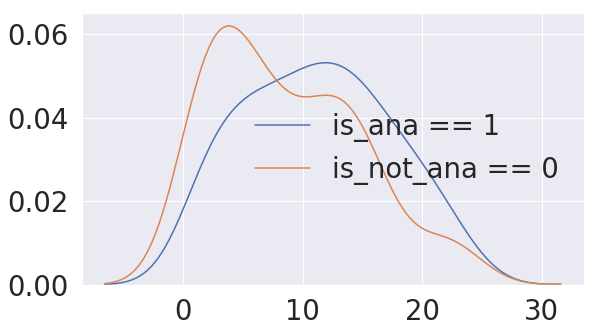

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['is_ana'] == 1]['token_dist'], ax=ax)
sns.kdeplot(df_train[df_train['is_ana'] == 0]['token_dist'], ax=ax)
plt.legend(['is_ana == 1', 'is_not_ana == 0'])
plt.show()

In [ ]:
# 널체크는 반복문 대신 agg를 사용할 수 있습니다.
df_train.agg(lambda x: sum(x.isnull()) / x.shape[0])

nr.                0.000000
etri_sent          0.000000
verb               0.000000
verb_roman         0.000000
candidate          0.000000
candidate_roman    0.000000
is_ana             0.000000
topic_ant          0.000000
head_ant           0.000000
beginning_ant      0.000000
sent_dist          0.000000
token_dist         0.000000
ant_syn            0.000000
zp_syn             0.000000
both_subj/dobj     0.000000
ant_speaker        0.000000
zp_speaker         0.000000
tense_zp           0.290909
morpho1            0.000000
morpho2            0.000000
morpho3            0.000000
morpho4            0.000000
morpho5            0.000000
morpho7            0.000000
morpho8            0.000000
morpho9            0.000000
connective_pred    0.863636
pred_A             0.000000
pred_B             0.000000
pred_C             0.000000
pred_D             0.000000
zp_hono            0.763636
zp_mood            0.281818
dtype: float64

**Exploratory data analysis**

In [ ]:
#Summary of the dataset
sample_data.describe()

,Unnamed: 0,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


**classification count**

In [ ]:
#classification count
sample_data['is_ana'].value_counts()

1    110
0    110
Name: is_ana, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "sent_dist", "token_dist", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]
categorical_feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]

In [ ]:
#split the dataset
#train dataset
train_features=sample_data.feature_names[:165]
train_is_anas=sample_data.is_ana[:165]
#test dataset
test_features=sample_data.feature_names[165:]
test_is_anas=sample_data.is_ana[165:]
print(train_features.shape,train_is_anas.shape)
print(test_features.shape,test_is_anas.shape)

AttributeError: ignored

In [ ]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

**Problem Statement:**

In this, we try to predict that if a zero subject anaphoric or non-anaphoric is by using LogisticRegression. (data: training_data_sample_102019.csv, 이를 split, feature를 One-hot Encoding을 통해 Engineering함, 테스트 점수: 0.80)

**Import necessary libraries**

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자(https://kaggle-kr.tistory.com/17)가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

**Import the training dataset**

In [ ]:
# Google Colab에서 Local Computer의 파일을 업로드할 수 있는 코드를 추가함
from google.colab import files
uploaded = files.upload()

Saving test_data_sample_102019.csv to test_data_sample_102019 (2).csv
Saving training_data_sample_102019.csv to training_data_sample_102019 (2).csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['training_data_sample_102019.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test_data_sample_102019.csv']))

# 이제 데이터셋이 판다스의 dataframe에 저장되었음, 추가한 코드들 덕분에 다시 아래 코드들이 정상적으로 돌아감
#importing the training data

In [ ]:
df_train.head(10)


,nr.,etri_sent,verb,verb_roman,candidate,candidate_roman,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,4529,부탁합니다,bu-tag-hab-ni-da,비행기시간,bi-hAN-gi-si-gan,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,1,4529,부탁합니다,bu-tag-hab-ni-da,거리,gO-li,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,2,4529,부탁합니다,bu-tag-hab-ni-da,밖,bagg,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,3,4726,맞는지,maj-nUn-ji,표,pyo,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,4,4726,맞는지,maj-nUn-ji,기차,gi-ca,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
5,5,4726,맞는지,maj-nUn-ji,파리행기차,pa-li-hAN-gi-ca,1,0,1,0,2,12,scom,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
6,6,4902,닫아주시길,dad-a-ju-si-gil,창문,caN-mun,0,0,0,0,0,2,modi,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
7,7,4902,닫아주시길,dad-a-ju-si-gil,덮개,dOp-gA,0,0,1,0,0,1,dobj,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
8,8,4902,닫아주시길,dad-a-ju-si-gil,비행기,bi-hAN-gi,0,0,1,0,0,4,subj,subj,1,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
9,9,4902,닫아주시길,dad-a-ju-si-gil,옆,yOp,0,0,0,0,3,16,modi,subj,0,A,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN


pandas dataframe 에는 describe() 메소드가 있는 데, 이를 쓰면 각 feature 가 가진 통계치들을 반환해줍니다.

In [ ]:
df_train.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


In [ ]:
df_test.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.000000,97.0,97.0,97.0,97.0
mean,1278.000000,4895.123711,0.206186,0.061856,0.525773,0.164948,1.412371,11.134021,0.309278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020619,0.0,0.0,0.0,0.0
std,28.145456,237.116368,0.406667,0.242145,0.501929,0.373062,1.048338,6.882388,0.464597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142842,0.0,0.0,0.0,0.0
min,1230.000000,4031.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
25%,1254.000000,4829.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
50%,1278.000000,5005.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
75%,1302.000000,5006.000000,0.000000,0.000000,1.000000,0.000000,2.000000,17.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
max,1326.000000,5009.000000,1.000000,1.000000,1.000000,1.000000,3.000000,27.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0


**범주형 데이터 문자열 확인하기**

*  데이터셋을 읽고 나면, 먼저 열에 어떤 의미 있는 범주형 데이터가 있는지 확인해보는 것이 좋습니다. 외부에서 다운받은 데이터일 경우, 정해진 범주 밖에 있을 수 있고, 철자 등의 typo가 있어서 데이터를 전처리해야 할 수 있습니다. 예를 들면 전화번호에 010-1234-5678과 01012345678처럼 같은 표현이지만 다르게 표현된 데이터가 있을 수 있습니다.

*  열의 내용을 확인하는 가장 좋은 방법은 pandas에서 Series에 있는 value_counts 함수를 사용하여 유일한 값이 각각 몇 번 나타나는 지 출력해보는 것입니다.

데이터 파일에서 feature들의 이름이 있는 열만 우선 불러오기.

In [ ]:
df_train.columns

Index(['nr.', 'etri_sent', 'verb', 'verb_roman', 'candidate',
       'candidate_roman', 'is_ana', 'topic_ant', 'head_ant', 'beginning_ant',
       'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj',
       'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2',
       'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9',
       'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono',
       'zp_mood'],
      dtype='object')

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
#feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
#categorical_feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
# categorical features는 전체 feature에서 continuous feature인 'sent_dist', 'token_dist'를 제외한 feature들이다.
print(df_train.topic_ant.value_counts())

0    212
1      8
Name: topic_ant, dtype: int64


topic_ant의 경우에는 0, 1로 에러없이 잘 나누어져있고, 정확하게 두 가지 값을 지니니 원-핫-인코딩으로 나타내기 좋은 형태입니다. 실제 데이터에서는 모든 열에 대해 확인해야 합니다.

In [ ]:
print(df_train.zp_hono.value_counts())

plus    52
Name: zp_hono, dtype: int64


zp_hono의 경우에는 honorific mark가 없는 것들은 N/A로 표시되었기 때문에 value_counts에서 plus 값만 보여준다.

pandas에서는 get_dummies 함수를 사용해 데이터를 매우 쉽게 인코딩할 수 있습니다. get_dummies 함수는 객체 타입이나 범주형을 가진 열을 자동으로 변환해줍니다.

In [ ]:
# 예제를 위해 is_ant(정답셋)을 포함한 feature들의 열만 선택합니다. 이 때 continuas feature도 포함합니다.
data = df_train[['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']]

display(data.head())

,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN


In [ ]:
print("original feature : \n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("get_dummies feature : \n", list(data_dummies.columns))

original feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj', 'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood'] 

get_dummies feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'both_subj/dobj', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'ant_syn_dobj', 'ant_syn_modi', 'ant_syn_root', 'ant_syn_scom', 'ant_syn_sub2', 'ant_syn_subj', 'zp_syn_subj', 'ant_speaker_A', 'ant_speaker_B', 'zp_speaker_A', 'zp_speaker_B', 'tense_zp_futu', 'tense_zp_past', 'tense_zp_pres', 'connective_pred_class_A', 'zp_hono_plus', 'zp_mood_decl', 'zp_mood_impe', 'zp_mood_ques']


data_dummies의 values 속성을 이용해 DataFrame을 NumPy 배열로 바꿀 수 있으며, 이를 이용해 머신러닝 모델을 학습시킵니다. 모델을 학습시키기 전에 이 데이터로부터 타깃값을 분리해야 합니다. 출력값이나 출력값으로부터 유도된 변수를 특성 표현에 포함하는 것은 지도 학습 모델을 만들 때 특히 저지를기 쉬운 실수입니다.

*  **CAUTION!**
  * pandas에서 열 인덱싱은 범위 끝을 포함합니다. 이와 달리 numpy는 끝 인덱싱은 범위 끝을 포함하지 않습니다.

여기서는 특성을 포함한 열, 즉 topic ant부터 zp_mood_ques까지 모든 열을 추출합니다. 이 범위에는 타깃(is_ana)을 뺀 모든 특성이 포함됩니다. (이 예제에서는 타깃값도 원-핫-인코딩으로 변환했지만, scikit-learn에서는 문자열도 타깃값으로 쓸 수 있으므로 imcome 열을 그대로 사용해도 됩니다.)

In [ ]:
features = data_dummies.loc[:, 'topic_ant':'zp_mood_ques']
# NumPy 배열 추출
X = features.values
y = data_dummies['is_ana'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))
# X.shape: (220, 37)  y.shape: (220,)

X.shape: (220, 37)  y.shape: (220,)


이제 데이터가 scikit-learn에서 사용할 수 있는 형태가 되었으므로, 로지스틱 회귀 분류기를 이용하면 됩니다.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(logreg.score(X_test, y_test)))
# 테스트 점수: 0.80

테스트 점수: 0.80


이 위의 코드까지가 LogisticRegression을 이용하여 test해본 결과

## Exploratory data analysis

*  이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.  
*  시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.  

### 1. zp_mood

*  먼저 zp_mood 에 대해서 살펴보겠습니다. zp_mood는 binary 데이터 타입입니다.  
*  먼저 zp_mood 에 따른 classification의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe 에서는 groupby 를 사용하면 쉽게 할 수 있습니다. 또한 pivot 이라는 메소드도 있습니다.
*  'zp_mood', 'is_ana' 를 가져온 후, zp_mood로 묶습니다. 그러고 나면 각 zp_mood마다 0, 1 이 count가 되는데, 이를 평균내면 각 zp_mood별 classification이 나옵니다
*  아래와 같이 count() 를 하면, 각 class 에 몇 개의 zp_mood가 있는 지 확인할 수 있으며, sum() 을 하면, 212개 중 anaphoric(is_ant=**1**)한 zero subject의 총합을 주게 됩니다

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).count()

,is_ana
zp_mood,
decl,109
impe,5
ques,44


=> training data에서 총 220개의 zero subject 중에 "zp_mood"라는 feature에서 N/A를 제외하면 총 158개의 zero subject 중에  109개가 decl(평서문)에서, 5개가 impe(명령문)에서, 44개가 ques(의문문)에서는 나타났다.

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).sum()

,is_ana
zp_mood,
decl,66
impe,0
ques,21


  *  pandas 의 crosstab 을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [ ]:
pd.crosstab(df_train['zp_mood'], df_train['is_ana'], margins=True).style.background_gradient(cmap='summer_r')

is_ana,0,1,All
zp_mood,,,
decl,43,66,109
impe,5,0,5
ques,23,21,44
All,71,87,158


  * grouped 객체에 mean() 을 하게 되면, 각 mood별 is_ana을 얻을 수 있습니다. decl이면 아래와 같습니다.

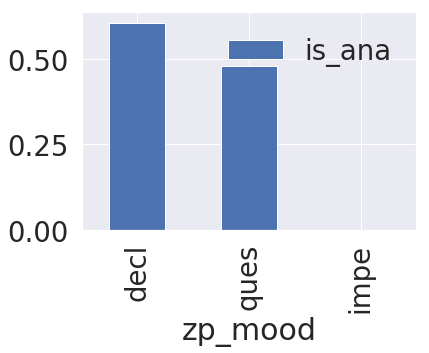

In [ ]:
df_train[['zp_mood', 'is_ana']].groupby(['zp_mood'], as_index=True).mean().sort_values(by='is_ana', ascending=False).plot.bar()

### 2. token_dist

*  이번에는 token_dist 를 살펴봅시다.

In [ ]:
print('제일 먼 token의 거리 : {:.1f} Tokens'.format(df_train['token_dist'].max()))
print('제일 가까운 token의 거리 : {:.1f} Token'.format(df_train['token_dist'].min()))
print('평균 token 거리 : {:.1f} Tokens'.format(df_train['token_dist'].mean()))

제일 먼 token의 거리 : 24.0 Tokens
제일 가까운 token의 거리 : 1.0 Token
평균 token 거리 : 9.9 Tokens


anaphoric에 따른 token_dist의 histogram 을 그려보겠습니다.


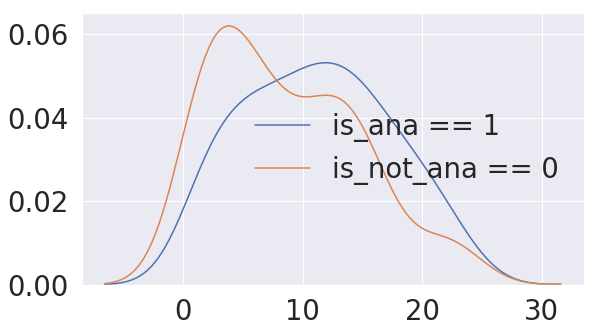

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['is_ana'] == 1]['token_dist'], ax=ax)
sns.kdeplot(df_train[df_train['is_ana'] == 0]['token_dist'], ax=ax)
plt.legend(['is_ana == 1', 'is_not_ana == 0'])
plt.show()

In [ ]:
# 널체크는 반복문 대신 agg를 사용할 수 있습니다.
df_train.agg(lambda x: sum(x.isnull()) / x.shape[0])

nr.                0.000000
etri_sent          0.000000
verb               0.000000
verb_roman         0.000000
candidate          0.000000
candidate_roman    0.000000
is_ana             0.000000
topic_ant          0.000000
head_ant           0.000000
beginning_ant      0.000000
sent_dist          0.000000
token_dist         0.000000
ant_syn            0.000000
zp_syn             0.000000
both_subj/dobj     0.000000
ant_speaker        0.000000
zp_speaker         0.000000
tense_zp           0.290909
morpho1            0.000000
morpho2            0.000000
morpho3            0.000000
morpho4            0.000000
morpho5            0.000000
morpho7            0.000000
morpho8            0.000000
morpho9            0.000000
connective_pred    0.863636
pred_A             0.000000
pred_B             0.000000
pred_C             0.000000
pred_D             0.000000
zp_hono            0.763636
zp_mood            0.281818
dtype: float64

**Exploratory data analysis**

In [ ]:
#Summary of the dataset
sample_data.describe()

,Unnamed: 0,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


**classification count**

In [ ]:
#classification count
sample_data['is_ana'].value_counts()

1    110
0    110
Name: is_ana, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "sent_dist", "token_dist", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]
categorical_feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]

In [ ]:
#split the dataset
#train dataset
train_features=sample_data.feature_names[:165]
train_is_anas=sample_data.is_ana[:165]
#test dataset
test_features=sample_data.feature_names[165:]
test_is_anas=sample_data.is_ana[165:]
print(train_features.shape,train_is_anas.shape)
print(test_features.shape,test_is_anas.shape)

AttributeError: ignored

In [ ]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

**Problem Statement:**

In this, we try to predict that if a zero subject anaphoric or non-anaphoric is by using LogisticRegression. (data: training_data_sample_102019.csv, 이를 split, feature를 One-hot Encoding을 통해 Engineering함, 테스트 점수: 0.80)

**Import necessary libraries**

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자(https://kaggle-kr.tistory.com/17)가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

**Import the training dataset**

In [ ]:
# Google Colab에서 Local Computer의 파일을 업로드할 수 있는 코드를 추가함
from google.colab import files
uploaded = files.upload()

Saving test_data_sample_102019.csv to test_data_sample_102019 (2).csv
Saving training_data_sample_102019.csv to training_data_sample_102019 (2).csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['training_data_sample_102019.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test_data_sample_102019.csv']))

# 이제 데이터셋이 판다스의 dataframe에 저장되었음, 추가한 코드들 덕분에 다시 아래 코드들이 정상적으로 돌아감
#importing the training data

In [ ]:
df_train.head(10)


,nr.,etri_sent,verb,verb_roman,candidate,candidate_roman,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,4529,부탁합니다,bu-tag-hab-ni-da,비행기시간,bi-hAN-gi-si-gan,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,1,4529,부탁합니다,bu-tag-hab-ni-da,거리,gO-li,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,2,4529,부탁합니다,bu-tag-hab-ni-da,밖,bagg,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,3,4726,맞는지,maj-nUn-ji,표,pyo,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,4,4726,맞는지,maj-nUn-ji,기차,gi-ca,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
5,5,4726,맞는지,maj-nUn-ji,파리행기차,pa-li-hAN-gi-ca,1,0,1,0,2,12,scom,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
6,6,4902,닫아주시길,dad-a-ju-si-gil,창문,caN-mun,0,0,0,0,0,2,modi,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
7,7,4902,닫아주시길,dad-a-ju-si-gil,덮개,dOp-gA,0,0,1,0,0,1,dobj,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
8,8,4902,닫아주시길,dad-a-ju-si-gil,비행기,bi-hAN-gi,0,0,1,0,0,4,subj,subj,1,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
9,9,4902,닫아주시길,dad-a-ju-si-gil,옆,yOp,0,0,0,0,3,16,modi,subj,0,A,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN


pandas dataframe 에는 describe() 메소드가 있는 데, 이를 쓰면 각 feature 가 가진 통계치들을 반환해줍니다.

In [ ]:
df_train.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


In [ ]:
df_test.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.000000,97.0,97.0,97.0,97.0
mean,1278.000000,4895.123711,0.206186,0.061856,0.525773,0.164948,1.412371,11.134021,0.309278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020619,0.0,0.0,0.0,0.0
std,28.145456,237.116368,0.406667,0.242145,0.501929,0.373062,1.048338,6.882388,0.464597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142842,0.0,0.0,0.0,0.0
min,1230.000000,4031.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
25%,1254.000000,4829.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
50%,1278.000000,5005.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
75%,1302.000000,5006.000000,0.000000,0.000000,1.000000,0.000000,2.000000,17.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
max,1326.000000,5009.000000,1.000000,1.000000,1.000000,1.000000,3.000000,27.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0


**범주형 데이터 문자열 확인하기**

*  데이터셋을 읽고 나면, 먼저 열에 어떤 의미 있는 범주형 데이터가 있는지 확인해보는 것이 좋습니다. 외부에서 다운받은 데이터일 경우, 정해진 범주 밖에 있을 수 있고, 철자 등의 typo가 있어서 데이터를 전처리해야 할 수 있습니다. 예를 들면 전화번호에 010-1234-5678과 01012345678처럼 같은 표현이지만 다르게 표현된 데이터가 있을 수 있습니다.

*  열의 내용을 확인하는 가장 좋은 방법은 pandas에서 Series에 있는 value_counts 함수를 사용하여 유일한 값이 각각 몇 번 나타나는 지 출력해보는 것입니다.

데이터 파일에서 feature들의 이름이 있는 열만 우선 불러오기.

In [ ]:
df_train.columns

Index(['nr.', 'etri_sent', 'verb', 'verb_roman', 'candidate',
       'candidate_roman', 'is_ana', 'topic_ant', 'head_ant', 'beginning_ant',
       'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj',
       'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2',
       'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9',
       'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono',
       'zp_mood'],
      dtype='object')

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
#feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
#categorical_feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
# categorical features는 전체 feature에서 continuous feature인 'sent_dist', 'token_dist'를 제외한 feature들이다.
print(df_train.topic_ant.value_counts())

0    212
1      8
Name: topic_ant, dtype: int64


topic_ant의 경우에는 0, 1로 에러없이 잘 나누어져있고, 정확하게 두 가지 값을 지니니 원-핫-인코딩으로 나타내기 좋은 형태입니다. 실제 데이터에서는 모든 열에 대해 확인해야 합니다.

In [ ]:
print(df_train.zp_hono.value_counts())

plus    52
Name: zp_hono, dtype: int64


zp_hono의 경우에는 honorific mark가 없는 것들은 N/A로 표시되었기 때문에 value_counts에서 plus 값만 보여준다.

pandas에서는 get_dummies 함수를 사용해 데이터를 매우 쉽게 인코딩할 수 있습니다. get_dummies 함수는 객체 타입이나 범주형을 가진 열을 자동으로 변환해줍니다.

In [ ]:
# 예제를 위해 is_ant(정답셋)을 포함한 feature들의 열만 선택합니다. 이 때 continuas feature도 포함합니다.
data = df_train[['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']]

display(data.head())

,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN


In [ ]:
print("original feature : \n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("get_dummies feature : \n", list(data_dummies.columns))

original feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj', 'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood'] 

get_dummies feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'both_subj/dobj', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'ant_syn_dobj', 'ant_syn_modi', 'ant_syn_root', 'ant_syn_scom', 'ant_syn_sub2', 'ant_syn_subj', 'zp_syn_subj', 'ant_speaker_A', 'ant_speaker_B', 'zp_speaker_A', 'zp_speaker_B', 'tense_zp_futu', 'tense_zp_past', 'tense_zp_pres', 'connective_pred_class_A', 'zp_hono_plus', 'zp_mood_decl', 'zp_mood_impe', 'zp_mood_ques']


data_dummies의 values 속성을 이용해 DataFrame을 NumPy 배열로 바꿀 수 있으며, 이를 이용해 머신러닝 모델을 학습시킵니다. 모델을 학습시키기 전에 이 데이터로부터 타깃값을 분리해야 합니다. 출력값이나 출력값으로부터 유도된 변수를 특성 표현에 포함하는 것은 지도 학습 모델을 만들 때 특히 저지를기 쉬운 실수입니다.

*  **CAUTION!**
  * pandas에서 열 인덱싱은 범위 끝을 포함합니다. 이와 달리 numpy는 끝 인덱싱은 범위 끝을 포함하지 않습니다.

여기서는 특성을 포함한 열, 즉 topic ant부터 zp_mood_ques까지 모든 열을 추출합니다. 이 범위에는 타깃(is_ana)을 뺀 모든 특성이 포함됩니다. (이 예제에서는 타깃값도 원-핫-인코딩으로 변환했지만, scikit-learn에서는 문자열도 타깃값으로 쓸 수 있으므로 imcome 열을 그대로 사용해도 됩니다.)

In [ ]:
features = data_dummies.loc[:, 'topic_ant':'zp_mood_ques']
# NumPy 배열 추출
X = features.values
y = data_dummies['is_ana'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))
# X.shape: (220, 37)  y.shape: (220,)

X.shape: (220, 37)  y.shape: (220,)


이제 데이터가 scikit-learn에서 사용할 수 있는 형태가 되었으므로, 로지스틱 회귀 분류기를 이용하면 됩니다.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(logreg.score(X_test, y_test)))
# 테스트 점수: 0.80

테스트 점수: 0.80


이 위의 코드까지가 LogisticRegression을 이용하여 test해본 결과

## Exploratory data analysis

*  이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.  
*  시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.  

### 1. zp_mood

*  먼저 zp_mood 에 대해서 살펴보겠습니다. zp_mood는 binary 데이터 타입입니다.  
*  먼저 zp_mood 에 따른 classification의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe 에서는 groupby 를 사용하면 쉽게 할 수 있습니다. 또한 pivot 이라는 메소드도 있습니다.
*  'zp_mood', 'is_ana' 를 가져온 후, zp_mood로 묶습니다. 그러고 나면 각 zp_mood마다 0, 1 이 count가 되는데, 이를 평균내면 각 zp_mood별 classification이 나옵니다
*  아래와 같이 count() 를 하면, 각 class 에 몇 개의 zp_mood가 있는 지 확인할 수 있으며, sum() 을 하면, 212개 중 anaphoric(is_ant=**1**)한 zero subject의 총합을 주게 됩니다

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).count()

,is_ana
zp_mood,
decl,109
impe,5
ques,44


=> training data에서 총 220개의 zero subject 중에 "zp_mood"라는 feature에서 N/A를 제외하면 총 158개의 zero subject 중에  109개가 decl(평서문)에서, 5개가 impe(명령문)에서, 44개가 ques(의문문)에서는 나타났다.

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).sum()

,is_ana
zp_mood,
decl,66
impe,0
ques,21


  *  pandas 의 crosstab 을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [ ]:
pd.crosstab(df_train['zp_mood'], df_train['is_ana'], margins=True).style.background_gradient(cmap='summer_r')

is_ana,0,1,All
zp_mood,,,
decl,43,66,109
impe,5,0,5
ques,23,21,44
All,71,87,158


  * grouped 객체에 mean() 을 하게 되면, 각 mood별 is_ana을 얻을 수 있습니다. decl이면 아래와 같습니다.

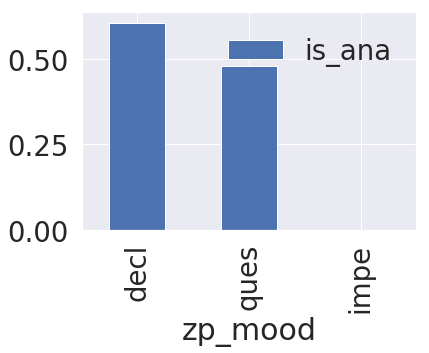

In [ ]:
df_train[['zp_mood', 'is_ana']].groupby(['zp_mood'], as_index=True).mean().sort_values(by='is_ana', ascending=False).plot.bar()

### 2. token_dist

*  이번에는 token_dist 를 살펴봅시다.

In [ ]:
print('제일 먼 token의 거리 : {:.1f} Tokens'.format(df_train['token_dist'].max()))
print('제일 가까운 token의 거리 : {:.1f} Token'.format(df_train['token_dist'].min()))
print('평균 token 거리 : {:.1f} Tokens'.format(df_train['token_dist'].mean()))

제일 먼 token의 거리 : 24.0 Tokens
제일 가까운 token의 거리 : 1.0 Token
평균 token 거리 : 9.9 Tokens


anaphoric에 따른 token_dist의 histogram 을 그려보겠습니다.


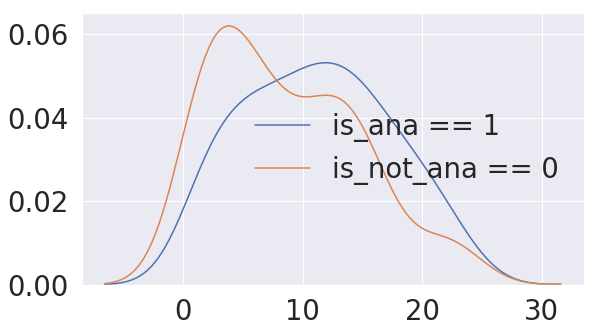

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['is_ana'] == 1]['token_dist'], ax=ax)
sns.kdeplot(df_train[df_train['is_ana'] == 0]['token_dist'], ax=ax)
plt.legend(['is_ana == 1', 'is_not_ana == 0'])
plt.show()

In [ ]:
# 널체크는 반복문 대신 agg를 사용할 수 있습니다.
df_train.agg(lambda x: sum(x.isnull()) / x.shape[0])

nr.                0.000000
etri_sent          0.000000
verb               0.000000
verb_roman         0.000000
candidate          0.000000
candidate_roman    0.000000
is_ana             0.000000
topic_ant          0.000000
head_ant           0.000000
beginning_ant      0.000000
sent_dist          0.000000
token_dist         0.000000
ant_syn            0.000000
zp_syn             0.000000
both_subj/dobj     0.000000
ant_speaker        0.000000
zp_speaker         0.000000
tense_zp           0.290909
morpho1            0.000000
morpho2            0.000000
morpho3            0.000000
morpho4            0.000000
morpho5            0.000000
morpho7            0.000000
morpho8            0.000000
morpho9            0.000000
connective_pred    0.863636
pred_A             0.000000
pred_B             0.000000
pred_C             0.000000
pred_D             0.000000
zp_hono            0.763636
zp_mood            0.281818
dtype: float64

**Exploratory data analysis**

In [ ]:
#Summary of the dataset
sample_data.describe()

,Unnamed: 0,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


**classification count**

In [ ]:
#classification count
sample_data['is_ana'].value_counts()

1    110
0    110
Name: is_ana, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "sent_dist", "token_dist", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]
categorical_feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]

In [ ]:
#split the dataset
#train dataset
train_features=sample_data.feature_names[:165]
train_is_anas=sample_data.is_ana[:165]
#test dataset
test_features=sample_data.feature_names[165:]
test_is_anas=sample_data.is_ana[165:]
print(train_features.shape,train_is_anas.shape)
print(test_features.shape,test_is_anas.shape)

AttributeError: ignored

In [ ]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

**Import necessary libraries**

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자(https://kaggle-kr.tistory.com/17)가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

**Import the training dataset**

In [ ]:
# Google Colab에서 Local Computer의 파일을 업로드할 수 있는 코드를 추가함
from google.colab import files
uploaded = files.upload()

Saving test_data_sample_102019.csv to test_data_sample_102019 (2).csv
Saving training_data_sample_102019.csv to training_data_sample_102019 (2).csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['training_data_sample_102019.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test_data_sample_102019.csv']))

# 이제 데이터셋이 판다스의 dataframe에 저장되었음, 추가한 코드들 덕분에 다시 아래 코드들이 정상적으로 돌아감
#importing the training data

In [ ]:
df_train.head(10)


,nr.,etri_sent,verb,verb_roman,candidate,candidate_roman,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,4529,부탁합니다,bu-tag-hab-ni-da,비행기시간,bi-hAN-gi-si-gan,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,1,4529,부탁합니다,bu-tag-hab-ni-da,거리,gO-li,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,2,4529,부탁합니다,bu-tag-hab-ni-da,밖,bagg,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,3,4726,맞는지,maj-nUn-ji,표,pyo,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,4,4726,맞는지,maj-nUn-ji,기차,gi-ca,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
5,5,4726,맞는지,maj-nUn-ji,파리행기차,pa-li-hAN-gi-ca,1,0,1,0,2,12,scom,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
6,6,4902,닫아주시길,dad-a-ju-si-gil,창문,caN-mun,0,0,0,0,0,2,modi,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
7,7,4902,닫아주시길,dad-a-ju-si-gil,덮개,dOp-gA,0,0,1,0,0,1,dobj,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
8,8,4902,닫아주시길,dad-a-ju-si-gil,비행기,bi-hAN-gi,0,0,1,0,0,4,subj,subj,1,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
9,9,4902,닫아주시길,dad-a-ju-si-gil,옆,yOp,0,0,0,0,3,16,modi,subj,0,A,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN


pandas dataframe 에는 describe() 메소드가 있는 데, 이를 쓰면 각 feature 가 가진 통계치들을 반환해줍니다.

In [ ]:
df_train.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


In [ ]:
df_test.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.000000,97.0,97.0,97.0,97.0
mean,1278.000000,4895.123711,0.206186,0.061856,0.525773,0.164948,1.412371,11.134021,0.309278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020619,0.0,0.0,0.0,0.0
std,28.145456,237.116368,0.406667,0.242145,0.501929,0.373062,1.048338,6.882388,0.464597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142842,0.0,0.0,0.0,0.0
min,1230.000000,4031.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
25%,1254.000000,4829.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
50%,1278.000000,5005.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
75%,1302.000000,5006.000000,0.000000,0.000000,1.000000,0.000000,2.000000,17.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
max,1326.000000,5009.000000,1.000000,1.000000,1.000000,1.000000,3.000000,27.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0


**범주형 데이터 문자열 확인하기**

*  데이터셋을 읽고 나면, 먼저 열에 어떤 의미 있는 범주형 데이터가 있는지 확인해보는 것이 좋습니다. 외부에서 다운받은 데이터일 경우, 정해진 범주 밖에 있을 수 있고, 철자 등의 typo가 있어서 데이터를 전처리해야 할 수 있습니다. 예를 들면 전화번호에 010-1234-5678과 01012345678처럼 같은 표현이지만 다르게 표현된 데이터가 있을 수 있습니다.

*  열의 내용을 확인하는 가장 좋은 방법은 pandas에서 Series에 있는 value_counts 함수를 사용하여 유일한 값이 각각 몇 번 나타나는 지 출력해보는 것입니다.

데이터 파일에서 feature들의 이름이 있는 열만 우선 불러오기.

In [ ]:
df_train.columns

Index(['nr.', 'etri_sent', 'verb', 'verb_roman', 'candidate',
       'candidate_roman', 'is_ana', 'topic_ant', 'head_ant', 'beginning_ant',
       'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj',
       'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2',
       'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9',
       'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono',
       'zp_mood'],
      dtype='object')

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
#feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
#categorical_feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
# categorical features는 전체 feature에서 continuous feature인 'sent_dist', 'token_dist'를 제외한 feature들이다.
print(df_train.topic_ant.value_counts())

0    212
1      8
Name: topic_ant, dtype: int64


topic_ant의 경우에는 0, 1로 에러없이 잘 나누어져있고, 정확하게 두 가지 값을 지니니 원-핫-인코딩으로 나타내기 좋은 형태입니다. 실제 데이터에서는 모든 열에 대해 확인해야 합니다.

In [ ]:
print(df_train.zp_hono.value_counts())

plus    52
Name: zp_hono, dtype: int64


zp_hono의 경우에는 honorific mark가 없는 것들은 N/A로 표시되었기 때문에 value_counts에서 plus 값만 보여준다.

pandas에서는 get_dummies 함수를 사용해 데이터를 매우 쉽게 인코딩할 수 있습니다. get_dummies 함수는 객체 타입이나 범주형을 가진 열을 자동으로 변환해줍니다.

In [ ]:
# 예제를 위해 is_ant(정답셋)을 포함한 feature들의 열만 선택합니다. 이 때 continuas feature도 포함합니다.
data = df_train[['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']]

display(data.head())

,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN


In [ ]:
print("original feature : \n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("get_dummies feature : \n", list(data_dummies.columns))

original feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj', 'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood'] 

get_dummies feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'both_subj/dobj', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'ant_syn_dobj', 'ant_syn_modi', 'ant_syn_root', 'ant_syn_scom', 'ant_syn_sub2', 'ant_syn_subj', 'zp_syn_subj', 'ant_speaker_A', 'ant_speaker_B', 'zp_speaker_A', 'zp_speaker_B', 'tense_zp_futu', 'tense_zp_past', 'tense_zp_pres', 'connective_pred_class_A', 'zp_hono_plus', 'zp_mood_decl', 'zp_mood_impe', 'zp_mood_ques']


data_dummies의 values 속성을 이용해 DataFrame을 NumPy 배열로 바꿀 수 있으며, 이를 이용해 머신러닝 모델을 학습시킵니다. 모델을 학습시키기 전에 이 데이터로부터 타깃값을 분리해야 합니다. 출력값이나 출력값으로부터 유도된 변수를 특성 표현에 포함하는 것은 지도 학습 모델을 만들 때 특히 저지를기 쉬운 실수입니다.

*  **CAUTION!**
  * pandas에서 열 인덱싱은 범위 끝을 포함합니다. 이와 달리 numpy는 끝 인덱싱은 범위 끝을 포함하지 않습니다.

여기서는 특성을 포함한 열, 즉 topic ant부터 zp_mood_ques까지 모든 열을 추출합니다. 이 범위에는 타깃(is_ana)을 뺀 모든 특성이 포함됩니다. (이 예제에서는 타깃값도 원-핫-인코딩으로 변환했지만, scikit-learn에서는 문자열도 타깃값으로 쓸 수 있으므로 imcome 열을 그대로 사용해도 됩니다.)

In [ ]:
features = data_dummies.loc[:, 'topic_ant':'zp_mood_ques']
# NumPy 배열 추출
X = features.values
y = data_dummies['is_ana'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))
# X.shape: (220, 37)  y.shape: (220,)

X.shape: (220, 37)  y.shape: (220,)


이제 데이터가 scikit-learn에서 사용할 수 있는 형태가 되었으므로, 로지스틱 회귀 분류기를 이용하면 됩니다.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(logreg.score(X_test, y_test)))
# 테스트 점수: 0.80

테스트 점수: 0.80


이 위의 코드까지가 LogisticRegression을 이용하여 test해본 결과

## Exploratory data analysis

*  이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.  
*  시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.  

### 1. zp_mood

*  먼저 zp_mood 에 대해서 살펴보겠습니다. zp_mood는 binary 데이터 타입입니다.  
*  먼저 zp_mood 에 따른 classification의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe 에서는 groupby 를 사용하면 쉽게 할 수 있습니다. 또한 pivot 이라는 메소드도 있습니다.
*  'zp_mood', 'is_ana' 를 가져온 후, zp_mood로 묶습니다. 그러고 나면 각 zp_mood마다 0, 1 이 count가 되는데, 이를 평균내면 각 zp_mood별 classification이 나옵니다
*  아래와 같이 count() 를 하면, 각 class 에 몇 개의 zp_mood가 있는 지 확인할 수 있으며, sum() 을 하면, 212개 중 anaphoric(is_ant=**1**)한 zero subject의 총합을 주게 됩니다

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).count()

,is_ana
zp_mood,
decl,109
impe,5
ques,44


=> training data에서 총 220개의 zero subject 중에 "zp_mood"라는 feature에서 N/A를 제외하면 총 158개의 zero subject 중에  109개가 decl(평서문)에서, 5개가 impe(명령문)에서, 44개가 ques(의문문)에서는 나타났다.

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).sum()

,is_ana
zp_mood,
decl,66
impe,0
ques,21


  *  pandas 의 crosstab 을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [ ]:
pd.crosstab(df_train['zp_mood'], df_train['is_ana'], margins=True).style.background_gradient(cmap='summer_r')

is_ana,0,1,All
zp_mood,,,
decl,43,66,109
impe,5,0,5
ques,23,21,44
All,71,87,158


  * grouped 객체에 mean() 을 하게 되면, 각 mood별 is_ana을 얻을 수 있습니다. decl이면 아래와 같습니다.

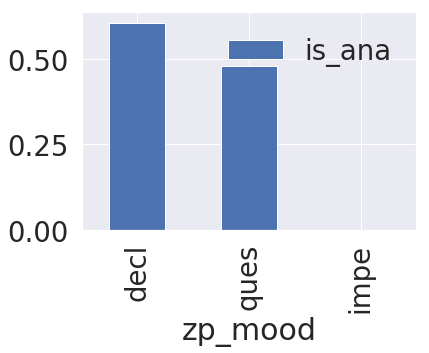

In [ ]:
df_train[['zp_mood', 'is_ana']].groupby(['zp_mood'], as_index=True).mean().sort_values(by='is_ana', ascending=False).plot.bar()

### 2. token_dist

*  이번에는 token_dist 를 살펴봅시다.

In [ ]:
print('제일 먼 token의 거리 : {:.1f} Tokens'.format(df_train['token_dist'].max()))
print('제일 가까운 token의 거리 : {:.1f} Token'.format(df_train['token_dist'].min()))
print('평균 token 거리 : {:.1f} Tokens'.format(df_train['token_dist'].mean()))

제일 먼 token의 거리 : 24.0 Tokens
제일 가까운 token의 거리 : 1.0 Token
평균 token 거리 : 9.9 Tokens


anaphoric에 따른 token_dist의 histogram 을 그려보겠습니다.


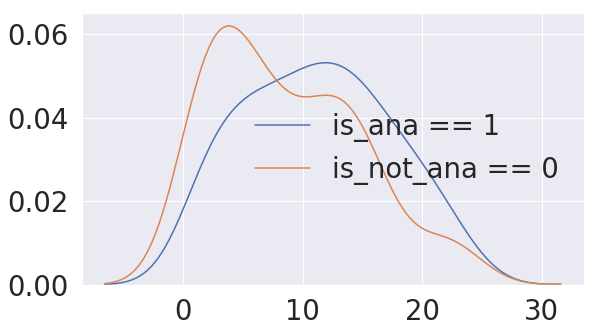

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['is_ana'] == 1]['token_dist'], ax=ax)
sns.kdeplot(df_train[df_train['is_ana'] == 0]['token_dist'], ax=ax)
plt.legend(['is_ana == 1', 'is_not_ana == 0'])
plt.show()

In [ ]:
# 널체크는 반복문 대신 agg를 사용할 수 있습니다.
df_train.agg(lambda x: sum(x.isnull()) / x.shape[0])

nr.                0.000000
etri_sent          0.000000
verb               0.000000
verb_roman         0.000000
candidate          0.000000
candidate_roman    0.000000
is_ana             0.000000
topic_ant          0.000000
head_ant           0.000000
beginning_ant      0.000000
sent_dist          0.000000
token_dist         0.000000
ant_syn            0.000000
zp_syn             0.000000
both_subj/dobj     0.000000
ant_speaker        0.000000
zp_speaker         0.000000
tense_zp           0.290909
morpho1            0.000000
morpho2            0.000000
morpho3            0.000000
morpho4            0.000000
morpho5            0.000000
morpho7            0.000000
morpho8            0.000000
morpho9            0.000000
connective_pred    0.863636
pred_A             0.000000
pred_B             0.000000
pred_C             0.000000
pred_D             0.000000
zp_hono            0.763636
zp_mood            0.281818
dtype: float64

**Exploratory data analysis**

In [ ]:
#Summary of the dataset
sample_data.describe()

,Unnamed: 0,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


**classification count**

In [ ]:
#classification count
sample_data['is_ana'].value_counts()

1    110
0    110
Name: is_ana, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "sent_dist", "token_dist", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]
categorical_feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]

In [ ]:
#split the dataset
#train dataset
train_features=sample_data.feature_names[:165]
train_is_anas=sample_data.is_ana[:165]
#test dataset
test_features=sample_data.feature_names[165:]
test_is_anas=sample_data.is_ana[165:]
print(train_features.shape,train_is_anas.shape)
print(test_features.shape,test_is_anas.shape)

AttributeError: ignored

In [ ]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

**Problem Statement:**

In this, we try to predict that if a zero subject anaphoric or non-anaphoric is by using LogisticRegression. (data: training_data_sample_102019.csv, 이를 split, feature를 One-hot Encoding을 통해 Engineering함, 테스트 점수: 0.80)

**Import necessary libraries**

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자(https://kaggle-kr.tistory.com/17)가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

**Import the training dataset**

In [ ]:
# Google Colab에서 Local Computer의 파일을 업로드할 수 있는 코드를 추가함
from google.colab import files
uploaded = files.upload()

Saving test_data_sample_102019.csv to test_data_sample_102019 (2).csv
Saving training_data_sample_102019.csv to training_data_sample_102019 (2).csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['training_data_sample_102019.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test_data_sample_102019.csv']))

# 이제 데이터셋이 판다스의 dataframe에 저장되었음, 추가한 코드들 덕분에 다시 아래 코드들이 정상적으로 돌아감
#importing the training data

In [ ]:
df_train.head(10)


,nr.,etri_sent,verb,verb_roman,candidate,candidate_roman,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,4529,부탁합니다,bu-tag-hab-ni-da,비행기시간,bi-hAN-gi-si-gan,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,1,4529,부탁합니다,bu-tag-hab-ni-da,거리,gO-li,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,2,4529,부탁합니다,bu-tag-hab-ni-da,밖,bagg,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,3,4726,맞는지,maj-nUn-ji,표,pyo,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,4,4726,맞는지,maj-nUn-ji,기차,gi-ca,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
5,5,4726,맞는지,maj-nUn-ji,파리행기차,pa-li-hAN-gi-ca,1,0,1,0,2,12,scom,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
6,6,4902,닫아주시길,dad-a-ju-si-gil,창문,caN-mun,0,0,0,0,0,2,modi,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
7,7,4902,닫아주시길,dad-a-ju-si-gil,덮개,dOp-gA,0,0,1,0,0,1,dobj,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
8,8,4902,닫아주시길,dad-a-ju-si-gil,비행기,bi-hAN-gi,0,0,1,0,0,4,subj,subj,1,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
9,9,4902,닫아주시길,dad-a-ju-si-gil,옆,yOp,0,0,0,0,3,16,modi,subj,0,A,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN


pandas dataframe 에는 describe() 메소드가 있는 데, 이를 쓰면 각 feature 가 가진 통계치들을 반환해줍니다.

In [ ]:
df_train.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


In [ ]:
df_test.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.000000,97.0,97.0,97.0,97.0
mean,1278.000000,4895.123711,0.206186,0.061856,0.525773,0.164948,1.412371,11.134021,0.309278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020619,0.0,0.0,0.0,0.0
std,28.145456,237.116368,0.406667,0.242145,0.501929,0.373062,1.048338,6.882388,0.464597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142842,0.0,0.0,0.0,0.0
min,1230.000000,4031.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
25%,1254.000000,4829.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
50%,1278.000000,5005.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
75%,1302.000000,5006.000000,0.000000,0.000000,1.000000,0.000000,2.000000,17.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
max,1326.000000,5009.000000,1.000000,1.000000,1.000000,1.000000,3.000000,27.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0


**범주형 데이터 문자열 확인하기**

*  데이터셋을 읽고 나면, 먼저 열에 어떤 의미 있는 범주형 데이터가 있는지 확인해보는 것이 좋습니다. 외부에서 다운받은 데이터일 경우, 정해진 범주 밖에 있을 수 있고, 철자 등의 typo가 있어서 데이터를 전처리해야 할 수 있습니다. 예를 들면 전화번호에 010-1234-5678과 01012345678처럼 같은 표현이지만 다르게 표현된 데이터가 있을 수 있습니다.

*  열의 내용을 확인하는 가장 좋은 방법은 pandas에서 Series에 있는 value_counts 함수를 사용하여 유일한 값이 각각 몇 번 나타나는 지 출력해보는 것입니다.

데이터 파일에서 feature들의 이름이 있는 열만 우선 불러오기.

In [ ]:
df_train.columns

Index(['nr.', 'etri_sent', 'verb', 'verb_roman', 'candidate',
       'candidate_roman', 'is_ana', 'topic_ant', 'head_ant', 'beginning_ant',
       'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj',
       'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2',
       'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9',
       'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono',
       'zp_mood'],
      dtype='object')

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
#feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
#categorical_feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
# categorical features는 전체 feature에서 continuous feature인 'sent_dist', 'token_dist'를 제외한 feature들이다.
print(df_train.topic_ant.value_counts())

0    212
1      8
Name: topic_ant, dtype: int64


topic_ant의 경우에는 0, 1로 에러없이 잘 나누어져있고, 정확하게 두 가지 값을 지니니 원-핫-인코딩으로 나타내기 좋은 형태입니다. 실제 데이터에서는 모든 열에 대해 확인해야 합니다.

In [ ]:
print(df_train.zp_hono.value_counts())

plus    52
Name: zp_hono, dtype: int64


zp_hono의 경우에는 honorific mark가 없는 것들은 N/A로 표시되었기 때문에 value_counts에서 plus 값만 보여준다.

pandas에서는 get_dummies 함수를 사용해 데이터를 매우 쉽게 인코딩할 수 있습니다. get_dummies 함수는 객체 타입이나 범주형을 가진 열을 자동으로 변환해줍니다.

In [ ]:
# 예제를 위해 is_ant(정답셋)을 포함한 feature들의 열만 선택합니다. 이 때 continuas feature도 포함합니다.
data = df_train[['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']]

display(data.head())

,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN


In [ ]:
print("original feature : \n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("get_dummies feature : \n", list(data_dummies.columns))

original feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj', 'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood'] 

get_dummies feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'both_subj/dobj', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'ant_syn_dobj', 'ant_syn_modi', 'ant_syn_root', 'ant_syn_scom', 'ant_syn_sub2', 'ant_syn_subj', 'zp_syn_subj', 'ant_speaker_A', 'ant_speaker_B', 'zp_speaker_A', 'zp_speaker_B', 'tense_zp_futu', 'tense_zp_past', 'tense_zp_pres', 'connective_pred_class_A', 'zp_hono_plus', 'zp_mood_decl', 'zp_mood_impe', 'zp_mood_ques']


data_dummies의 values 속성을 이용해 DataFrame을 NumPy 배열로 바꿀 수 있으며, 이를 이용해 머신러닝 모델을 학습시킵니다. 모델을 학습시키기 전에 이 데이터로부터 타깃값을 분리해야 합니다. 출력값이나 출력값으로부터 유도된 변수를 특성 표현에 포함하는 것은 지도 학습 모델을 만들 때 특히 저지를기 쉬운 실수입니다.

*  **CAUTION!**
  * pandas에서 열 인덱싱은 범위 끝을 포함합니다. 이와 달리 numpy는 끝 인덱싱은 범위 끝을 포함하지 않습니다.

여기서는 특성을 포함한 열, 즉 topic ant부터 zp_mood_ques까지 모든 열을 추출합니다. 이 범위에는 타깃(is_ana)을 뺀 모든 특성이 포함됩니다. (이 예제에서는 타깃값도 원-핫-인코딩으로 변환했지만, scikit-learn에서는 문자열도 타깃값으로 쓸 수 있으므로 imcome 열을 그대로 사용해도 됩니다.)

In [ ]:
features = data_dummies.loc[:, 'topic_ant':'zp_mood_ques']
# NumPy 배열 추출
X = features.values
y = data_dummies['is_ana'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))
# X.shape: (220, 37)  y.shape: (220,)

X.shape: (220, 37)  y.shape: (220,)


이제 데이터가 scikit-learn에서 사용할 수 있는 형태가 되었으므로, 로지스틱 회귀 분류기를 이용하면 됩니다.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(logreg.score(X_test, y_test)))
# 테스트 점수: 0.80

테스트 점수: 0.80


이 위의 코드까지가 LogisticRegression을 이용하여 test해본 결과

## Exploratory data analysis

*  이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.  
*  시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.  

### 1. zp_mood

*  먼저 zp_mood 에 대해서 살펴보겠습니다. zp_mood는 binary 데이터 타입입니다.  
*  먼저 zp_mood 에 따른 classification의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe 에서는 groupby 를 사용하면 쉽게 할 수 있습니다. 또한 pivot 이라는 메소드도 있습니다.
*  'zp_mood', 'is_ana' 를 가져온 후, zp_mood로 묶습니다. 그러고 나면 각 zp_mood마다 0, 1 이 count가 되는데, 이를 평균내면 각 zp_mood별 classification이 나옵니다
*  아래와 같이 count() 를 하면, 각 class 에 몇 개의 zp_mood가 있는 지 확인할 수 있으며, sum() 을 하면, 212개 중 anaphoric(is_ant=**1**)한 zero subject의 총합을 주게 됩니다

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).count()

,is_ana
zp_mood,
decl,109
impe,5
ques,44


=> training data에서 총 220개의 zero subject 중에 "zp_mood"라는 feature에서 N/A를 제외하면 총 158개의 zero subject 중에  109개가 decl(평서문)에서, 5개가 impe(명령문)에서, 44개가 ques(의문문)에서는 나타났다.

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).sum()

,is_ana
zp_mood,
decl,66
impe,0
ques,21


  *  pandas 의 crosstab 을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [ ]:
pd.crosstab(df_train['zp_mood'], df_train['is_ana'], margins=True).style.background_gradient(cmap='summer_r')

is_ana,0,1,All
zp_mood,,,
decl,43,66,109
impe,5,0,5
ques,23,21,44
All,71,87,158


  * grouped 객체에 mean() 을 하게 되면, 각 mood별 is_ana을 얻을 수 있습니다. decl이면 아래와 같습니다.

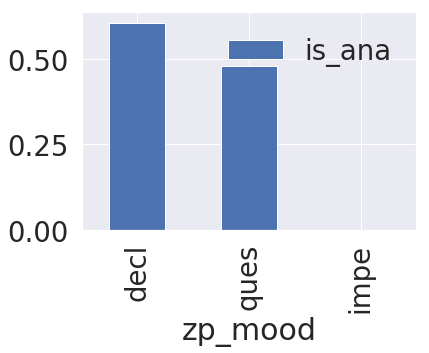

In [ ]:
df_train[['zp_mood', 'is_ana']].groupby(['zp_mood'], as_index=True).mean().sort_values(by='is_ana', ascending=False).plot.bar()

### 2. token_dist

*  이번에는 token_dist 를 살펴봅시다.

In [ ]:
print('제일 먼 token의 거리 : {:.1f} Tokens'.format(df_train['token_dist'].max()))
print('제일 가까운 token의 거리 : {:.1f} Token'.format(df_train['token_dist'].min()))
print('평균 token 거리 : {:.1f} Tokens'.format(df_train['token_dist'].mean()))

제일 먼 token의 거리 : 24.0 Tokens
제일 가까운 token의 거리 : 1.0 Token
평균 token 거리 : 9.9 Tokens


anaphoric에 따른 token_dist의 histogram 을 그려보겠습니다.


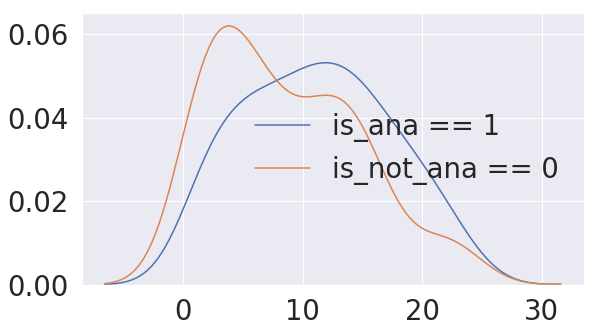

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['is_ana'] == 1]['token_dist'], ax=ax)
sns.kdeplot(df_train[df_train['is_ana'] == 0]['token_dist'], ax=ax)
plt.legend(['is_ana == 1', 'is_not_ana == 0'])
plt.show()

In [ ]:
# 널체크는 반복문 대신 agg를 사용할 수 있습니다.
df_train.agg(lambda x: sum(x.isnull()) / x.shape[0])

nr.                0.000000
etri_sent          0.000000
verb               0.000000
verb_roman         0.000000
candidate          0.000000
candidate_roman    0.000000
is_ana             0.000000
topic_ant          0.000000
head_ant           0.000000
beginning_ant      0.000000
sent_dist          0.000000
token_dist         0.000000
ant_syn            0.000000
zp_syn             0.000000
both_subj/dobj     0.000000
ant_speaker        0.000000
zp_speaker         0.000000
tense_zp           0.290909
morpho1            0.000000
morpho2            0.000000
morpho3            0.000000
morpho4            0.000000
morpho5            0.000000
morpho7            0.000000
morpho8            0.000000
morpho9            0.000000
connective_pred    0.863636
pred_A             0.000000
pred_B             0.000000
pred_C             0.000000
pred_D             0.000000
zp_hono            0.763636
zp_mood            0.281818
dtype: float64

**Exploratory data analysis**

In [ ]:
#Summary of the dataset
sample_data.describe()

,Unnamed: 0,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


**classification count**

In [ ]:
#classification count
sample_data['is_ana'].value_counts()

1    110
0    110
Name: is_ana, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "sent_dist", "token_dist", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]
categorical_feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]

In [ ]:
#split the dataset
#train dataset
train_features=sample_data.feature_names[:165]
train_is_anas=sample_data.is_ana[:165]
#test dataset
test_features=sample_data.feature_names[165:]
test_is_anas=sample_data.is_ana[165:]
print(train_features.shape,train_is_anas.shape)
print(test_features.shape,test_is_anas.shape)

AttributeError: ignored

In [ ]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

**Import necessary libraries**

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자(https://kaggle-kr.tistory.com/17)가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

**Import the training dataset**

In [ ]:
# Google Colab에서 Local Computer의 파일을 업로드할 수 있는 코드를 추가함
from google.colab import files
uploaded = files.upload()

Saving test_data_sample_102019.csv to test_data_sample_102019 (2).csv
Saving training_data_sample_102019.csv to training_data_sample_102019 (2).csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['training_data_sample_102019.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test_data_sample_102019.csv']))

# 이제 데이터셋이 판다스의 dataframe에 저장되었음, 추가한 코드들 덕분에 다시 아래 코드들이 정상적으로 돌아감
#importing the training data

In [ ]:
df_train.head(10)


,nr.,etri_sent,verb,verb_roman,candidate,candidate_roman,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,4529,부탁합니다,bu-tag-hab-ni-da,비행기시간,bi-hAN-gi-si-gan,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,1,4529,부탁합니다,bu-tag-hab-ni-da,거리,gO-li,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,2,4529,부탁합니다,bu-tag-hab-ni-da,밖,bagg,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,3,4726,맞는지,maj-nUn-ji,표,pyo,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,4,4726,맞는지,maj-nUn-ji,기차,gi-ca,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
5,5,4726,맞는지,maj-nUn-ji,파리행기차,pa-li-hAN-gi-ca,1,0,1,0,2,12,scom,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
6,6,4902,닫아주시길,dad-a-ju-si-gil,창문,caN-mun,0,0,0,0,0,2,modi,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
7,7,4902,닫아주시길,dad-a-ju-si-gil,덮개,dOp-gA,0,0,1,0,0,1,dobj,subj,0,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
8,8,4902,닫아주시길,dad-a-ju-si-gil,비행기,bi-hAN-gi,0,0,1,0,0,4,subj,subj,1,B,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN
9,9,4902,닫아주시길,dad-a-ju-si-gil,옆,yOp,0,0,0,0,3,16,modi,subj,0,A,B,NaN,0,0,0,0,0,0,0,1,NaN,0,0,0,0,plus,NaN


pandas dataframe 에는 describe() 메소드가 있는 데, 이를 쓰면 각 feature 가 가진 통계치들을 반환해줍니다.

In [ ]:
df_train.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


In [ ]:
df_test.describe()

,nr.,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.000000,97.0,97.0,97.0,97.0
mean,1278.000000,4895.123711,0.206186,0.061856,0.525773,0.164948,1.412371,11.134021,0.309278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020619,0.0,0.0,0.0,0.0
std,28.145456,237.116368,0.406667,0.242145,0.501929,0.373062,1.048338,6.882388,0.464597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142842,0.0,0.0,0.0,0.0
min,1230.000000,4031.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
25%,1254.000000,4829.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
50%,1278.000000,5005.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
75%,1302.000000,5006.000000,0.000000,0.000000,1.000000,0.000000,2.000000,17.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
max,1326.000000,5009.000000,1.000000,1.000000,1.000000,1.000000,3.000000,27.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0


**범주형 데이터 문자열 확인하기**

*  데이터셋을 읽고 나면, 먼저 열에 어떤 의미 있는 범주형 데이터가 있는지 확인해보는 것이 좋습니다. 외부에서 다운받은 데이터일 경우, 정해진 범주 밖에 있을 수 있고, 철자 등의 typo가 있어서 데이터를 전처리해야 할 수 있습니다. 예를 들면 전화번호에 010-1234-5678과 01012345678처럼 같은 표현이지만 다르게 표현된 데이터가 있을 수 있습니다.

*  열의 내용을 확인하는 가장 좋은 방법은 pandas에서 Series에 있는 value_counts 함수를 사용하여 유일한 값이 각각 몇 번 나타나는 지 출력해보는 것입니다.

데이터 파일에서 feature들의 이름이 있는 열만 우선 불러오기.

In [ ]:
df_train.columns

Index(['nr.', 'etri_sent', 'verb', 'verb_roman', 'candidate',
       'candidate_roman', 'is_ana', 'topic_ant', 'head_ant', 'beginning_ant',
       'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj',
       'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2',
       'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9',
       'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono',
       'zp_mood'],
      dtype='object')

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
#feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
#categorical_feature_names = ['topic_ant', 'head_ant', 'beginning_ant', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']
# categorical features는 전체 feature에서 continuous feature인 'sent_dist', 'token_dist'를 제외한 feature들이다.
print(df_train.topic_ant.value_counts())

0    212
1      8
Name: topic_ant, dtype: int64


topic_ant의 경우에는 0, 1로 에러없이 잘 나누어져있고, 정확하게 두 가지 값을 지니니 원-핫-인코딩으로 나타내기 좋은 형태입니다. 실제 데이터에서는 모든 열에 대해 확인해야 합니다.

In [ ]:
print(df_train.zp_hono.value_counts())

plus    52
Name: zp_hono, dtype: int64


zp_hono의 경우에는 honorific mark가 없는 것들은 N/A로 표시되었기 때문에 value_counts에서 plus 값만 보여준다.

pandas에서는 get_dummies 함수를 사용해 데이터를 매우 쉽게 인코딩할 수 있습니다. get_dummies 함수는 객체 타입이나 범주형을 가진 열을 자동으로 변환해줍니다.

In [ ]:
# 예제를 위해 is_ant(정답셋)을 포함한 feature들의 열만 선택합니다. 이 때 continuas feature도 포함합니다.
data = df_train[['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj','ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood']]

display(data.head())

,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,ant_syn,zp_syn,both_subj/dobj,ant_speaker,zp_speaker,tense_zp,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,connective_pred,pred_A,pred_B,pred_C,pred_D,zp_hono,zp_mood
0,0,0,1,0,0,4,subj,subj,1,A,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
1,0,0,1,0,1,8,scom,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
2,0,0,0,0,2,14,modi,subj,0,B,A,pres,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,decl
3,1,0,1,0,0,3,dobj,subj,0,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN
4,1,0,1,0,2,15,subj,subj,1,A,A,NaN,0,0,0,0,0,0,0,0,NaN,0,0,0,0,NaN,NaN


In [ ]:
print("original feature : \n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("get_dummies feature : \n", list(data_dummies.columns))

original feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'ant_syn', 'zp_syn', 'both_subj/dobj', 'ant_speaker', 'zp_speaker', 'tense_zp', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'connective_pred', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'zp_hono', 'zp_mood'] 

get_dummies feature : 
 ['is_ana', 'topic_ant', 'head_ant', 'beginning_ant', 'sent_dist', 'token_dist', 'both_subj/dobj', 'morpho1', 'morpho2', 'morpho3', 'morpho4', 'morpho5', 'morpho7', 'morpho8', 'morpho9', 'pred_A', 'pred_B', 'pred_C', 'pred_D', 'ant_syn_dobj', 'ant_syn_modi', 'ant_syn_root', 'ant_syn_scom', 'ant_syn_sub2', 'ant_syn_subj', 'zp_syn_subj', 'ant_speaker_A', 'ant_speaker_B', 'zp_speaker_A', 'zp_speaker_B', 'tense_zp_futu', 'tense_zp_past', 'tense_zp_pres', 'connective_pred_class_A', 'zp_hono_plus', 'zp_mood_decl', 'zp_mood_impe', 'zp_mood_ques']


data_dummies의 values 속성을 이용해 DataFrame을 NumPy 배열로 바꿀 수 있으며, 이를 이용해 머신러닝 모델을 학습시킵니다. 모델을 학습시키기 전에 이 데이터로부터 타깃값을 분리해야 합니다. 출력값이나 출력값으로부터 유도된 변수를 특성 표현에 포함하는 것은 지도 학습 모델을 만들 때 특히 저지를기 쉬운 실수입니다.

*  **CAUTION!**
  * pandas에서 열 인덱싱은 범위 끝을 포함합니다. 이와 달리 numpy는 끝 인덱싱은 범위 끝을 포함하지 않습니다.

여기서는 특성을 포함한 열, 즉 topic ant부터 zp_mood_ques까지 모든 열을 추출합니다. 이 범위에는 타깃(is_ana)을 뺀 모든 특성이 포함됩니다. (이 예제에서는 타깃값도 원-핫-인코딩으로 변환했지만, scikit-learn에서는 문자열도 타깃값으로 쓸 수 있으므로 imcome 열을 그대로 사용해도 됩니다.)

In [ ]:
features = data_dummies.loc[:, 'topic_ant':'zp_mood_ques']
# NumPy 배열 추출
X = features.values
y = data_dummies['is_ana'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))
# X.shape: (220, 37)  y.shape: (220,)

X.shape: (220, 37)  y.shape: (220,)


이제 데이터가 scikit-learn에서 사용할 수 있는 형태가 되었으므로, 로지스틱 회귀 분류기를 이용하면 됩니다.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(logreg.score(X_test, y_test)))
# 테스트 점수: 0.80

테스트 점수: 0.80


이 위의 코드까지가 LogisticRegression을 이용하여 test해본 결과

## Exploratory data analysis

*  이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.  
*  시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.  

### 1. zp_mood

*  먼저 zp_mood 에 대해서 살펴보겠습니다. zp_mood는 binary 데이터 타입입니다.  
*  먼저 zp_mood 에 따른 classification의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe 에서는 groupby 를 사용하면 쉽게 할 수 있습니다. 또한 pivot 이라는 메소드도 있습니다.
*  'zp_mood', 'is_ana' 를 가져온 후, zp_mood로 묶습니다. 그러고 나면 각 zp_mood마다 0, 1 이 count가 되는데, 이를 평균내면 각 zp_mood별 classification이 나옵니다
*  아래와 같이 count() 를 하면, 각 class 에 몇 개의 zp_mood가 있는 지 확인할 수 있으며, sum() 을 하면, 212개 중 anaphoric(is_ant=**1**)한 zero subject의 총합을 주게 됩니다

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).count()

,is_ana
zp_mood,
decl,109
impe,5
ques,44


=> training data에서 총 220개의 zero subject 중에 "zp_mood"라는 feature에서 N/A를 제외하면 총 158개의 zero subject 중에  109개가 decl(평서문)에서, 5개가 impe(명령문)에서, 44개가 ques(의문문)에서는 나타났다.

In [ ]:
df_train[["zp_mood", "is_ana"]].groupby(["zp_mood"], as_index=True).sum()

,is_ana
zp_mood,
decl,66
impe,0
ques,21


  *  pandas 의 crosstab 을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [ ]:
pd.crosstab(df_train['zp_mood'], df_train['is_ana'], margins=True).style.background_gradient(cmap='summer_r')

is_ana,0,1,All
zp_mood,,,
decl,43,66,109
impe,5,0,5
ques,23,21,44
All,71,87,158


  * grouped 객체에 mean() 을 하게 되면, 각 mood별 is_ana을 얻을 수 있습니다. decl이면 아래와 같습니다.

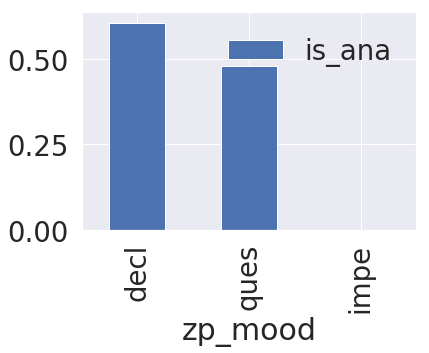

In [ ]:
df_train[['zp_mood', 'is_ana']].groupby(['zp_mood'], as_index=True).mean().sort_values(by='is_ana', ascending=False).plot.bar()

### 2. token_dist

*  이번에는 token_dist 를 살펴봅시다.

In [ ]:
print('제일 먼 token의 거리 : {:.1f} Tokens'.format(df_train['token_dist'].max()))
print('제일 가까운 token의 거리 : {:.1f} Token'.format(df_train['token_dist'].min()))
print('평균 token 거리 : {:.1f} Tokens'.format(df_train['token_dist'].mean()))

제일 먼 token의 거리 : 24.0 Tokens
제일 가까운 token의 거리 : 1.0 Token
평균 token 거리 : 9.9 Tokens


anaphoric에 따른 token_dist의 histogram 을 그려보겠습니다.


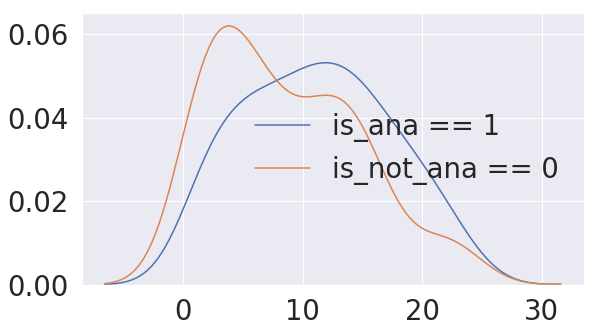

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['is_ana'] == 1]['token_dist'], ax=ax)
sns.kdeplot(df_train[df_train['is_ana'] == 0]['token_dist'], ax=ax)
plt.legend(['is_ana == 1', 'is_not_ana == 0'])
plt.show()

In [ ]:
# 널체크는 반복문 대신 agg를 사용할 수 있습니다.
df_train.agg(lambda x: sum(x.isnull()) / x.shape[0])

nr.                0.000000
etri_sent          0.000000
verb               0.000000
verb_roman         0.000000
candidate          0.000000
candidate_roman    0.000000
is_ana             0.000000
topic_ant          0.000000
head_ant           0.000000
beginning_ant      0.000000
sent_dist          0.000000
token_dist         0.000000
ant_syn            0.000000
zp_syn             0.000000
both_subj/dobj     0.000000
ant_speaker        0.000000
zp_speaker         0.000000
tense_zp           0.290909
morpho1            0.000000
morpho2            0.000000
morpho3            0.000000
morpho4            0.000000
morpho5            0.000000
morpho7            0.000000
morpho8            0.000000
morpho9            0.000000
connective_pred    0.863636
pred_A             0.000000
pred_B             0.000000
pred_C             0.000000
pred_D             0.000000
zp_hono            0.763636
zp_mood            0.281818
dtype: float64

**Exploratory data analysis**

In [ ]:
#Summary of the dataset
sample_data.describe()

,Unnamed: 0,etri_sent,is_ana,topic_ant,head_ant,beginning_ant,sent_dist,token_dist,both_subj/dobj,morpho1,morpho2,morpho3,morpho4,morpho5,morpho7,morpho8,morpho9,pred_A,pred_B,pred_C,pred_D
count,220.000000,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000,220.0,220.000000,220.0,220.0,220.0,220.000000,220.0,220.0,220.000000,220.0
mean,379.490909,4649.790909,0.50000,0.036364,0.636364,0.154545,1.472727,9.936364,0.172727,0.0,0.081818,0.0,0.013636,0.0,0.0,0.0,0.050000,0.0,0.0,0.027273,0.0
std,397.219370,257.180732,0.50114,0.187620,0.482143,0.362295,1.124319,6.233328,0.378873,0.0,0.274713,0.0,0.116240,0.0,0.0,0.0,0.218442,0.0,0.0,0.163248,0.0
min,0.000000,4041.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,54.750000,4540.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,130.500000,4727.500000,0.50000,0.000000,1.000000,0.000000,2.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,665.250000,4900.000000,1.00000,0.000000,1.000000,0.000000,2.000000,14.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1229.000000,4995.000000,1.00000,1.000000,1.000000,1.000000,3.000000,24.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0


**classification count**

In [ ]:
#classification count
sample_data['is_ana'].value_counts()

1    110
0    110
Name: is_ana, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [ ]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "sent_dist", "token_dist", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]
categorical_feature_names = ["topic_ant",	"head_ant",	"beginning_ant", "both_subj/dobj",	"morpho1",	"morpho2",	"morpho3",	"morpho4",	"morpho5",	"morpho7",	"morpho8",	"morpho9",	"pred_A",	"pred_B",	"pred_C",	"pred_D"]

In [ ]:
#split the dataset
#train dataset
train_features=sample_data.feature_names[:165]
train_is_anas=sample_data.is_ana[:165]
#test dataset
test_features=sample_data.feature_names[165:]
test_is_anas=sample_data.is_ana[165:]
print(train_features.shape,train_is_anas.shape)
print(test_features.shape,test_is_anas.shape)

AttributeError: ignored

In [ ]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data